<a href="https://colab.research.google.com/github/Hemantr05/Conversational_AIBots/blob/master/hands-on/Biomedical_Images_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Images Segmentation

Along this notebook we'll explain how to use the power of cloud computing with Google Colab for a non-so-classical example, we are going to do biomedical image segmentation based on the [ISBI Challenge](http://brainiac2.mit.edu/isbi_challenge/).

For this classification problem we will build a nice and elaborated convolutional neural network, based on **U-Net: Convolutional Networks for Biomedical Image Segmentation** ([*Ronneberger et. al*](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)).

The Python framework that we will be using is [Tensorflow 2.0](https://www.tensorflow.org) with the [Keras](https://keras.io/) module.


### Problem statement

Before we tackle the problem an elegant CNN, let's understand what we'll be doing: 

* If we feed our neural network with raw biomedical data, the model should be able to create a segmentation map for the input image.

> #### What do we need to do?
> Train a _Deep Learning_ model (in this case) using a dataset from a challenge: [ISBI Challenge](http://brainiac2.mit.edu/isbi_challenge/).
>
> Specifically, we are going to do the following:
> - Load the dataset
> - Preprocess the data
> - Build the model
> - Set hyperparameters 
> - Train the model
> - Save and download the trained model
> - Predict data

## Installing dependencies

For our training we will be using Tensorflow 2.0, so we want to be sure it is installed on its latest version:

In [ ]:
# Let's install Tensorflow 2.0:
!pip install -q tensorflow==2.0.0-rc0

# And verify that it is now in its latest version:
import tensorflow as tf
print(tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-rc0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.0+zzzcolab20220506153740, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.4+zzzcolab20220516125453, 2.6.5, 2.6.5+zzzcolab20220523104206, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.0+zzzcolab20220506150900, 2.7.1, 2.7.2, 2.7.2+zzzcolab20220516114640, 2.7.3, 2.7.3+zzzcolab20220523111007, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.0+zzzcolab20220506162203, 2.8.1, 2.8.1+zzzcolab20220516111314, 2.8.1+zzzcolab20220518083849, 2.8.2, 2.8.2+zzzcolab20220523105045, 2.8.2+zzzcolab20220527125636, 2.8.2+zzzcolab20220629235552, 2.8.2+zzzcolab20220714152931, 2.8.2+zzzcolab20220714162028, 2.8.2+zzzcolab20220719082949, 2.8.2+zzzcolab2022082

## The membrane dataset

About the dataset...

In [ ]:
!wget https://github.com/RodolfoFerro/RIIAA19-DLaaS/raw/master/data/membrane.zip
!unzip membrane.zip

--2022-09-20 17:24:01--  https://github.com/RodolfoFerro/RIIAA19-DLaaS/raw/master/data/membrane.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RodolfoFerro/RIIAA19-DLaaS/master/data/membrane.zip [following]
--2022-09-20 17:24:01--  https://raw.githubusercontent.com/RodolfoFerro/RIIAA19-DLaaS/master/data/membrane.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12892235 (12M) [application/zip]
Saving to: ‘membrane.zip’

membrane.zip        100%[===================>]  12.29M  --.-KB/s    in 0.07s   

2022-09-20 17:24:02 (165 MB/s) - ‘membrane.zip’ saved [12892235/12892235]

Archive:  m

In [ ]:
!ls membrane
!ls membrane/test
!ls membrane/train

test  train
0.png	12.png	15.png	18.png	20.png	23.png	26.png	29.png	4.png  7.png
10.png	13.png	16.png	19.png	21.png	24.png	27.png	2.png	5.png  8.png
11.png	14.png	17.png	1.png	22.png	25.png	28.png	3.png	6.png  9.png
image  label


In [ ]:
from glob import glob

training_path_img = sorted(glob("/content/membrane/train/image/*"))
training_path_lbl = sorted(glob("/content/membrane/train/label/*"))

## Importing the dataset

In [ ]:
# Importing the dataset with OpenCV and other useful packages:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# We will fix a random seed for reproducibility:
seed = 11
np.random.seed(seed)

# Loading function:
def image_loader(images_list):
    """Function to load images into arrays from folder path."""

    images = []
    for image in images_list:
        img = cv2.imread(image)
        images.append(img[:,:,0])
    
    return np.array(images)

# Data processor:
def image_generator(images, fraction=2):
    def image_cropper(image, fraction):
        w, h = image.shape[:2]
        wbase, hbase = w//fraction, h//fraction
        cropped_images = []
        for i in range(fraction):
            for j in range(fraction):
                a = i*hbase
                b = i*hbase + hbase
                c = j*wbase
                d = j*wbase + wbase
                img = image[a:b, c:d]
                cropped_images.append(img)
        return np.array(cropped_images)
    
    cropped_images = []
    for image in images:
        for img in image_cropper(image, fraction):
            cropped_images.append(img)
    
    return np.array(cropped_images)

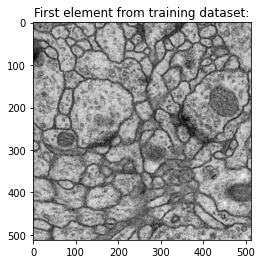

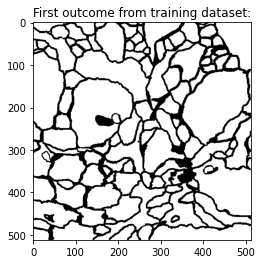

In [ ]:
# We now import the Iris dataset:
x_train = image_loader(training_path_img)
y_train = image_loader(training_path_lbl)

# Display first element from (x_train, y_train):
plt.figure()
plt.title("First element from training dataset:")
plt.imshow(x_train[0], cmap="gray")

plt.figure()
plt.title("First outcome from training dataset:")
plt.imshow(y_train[0], cmap="gray")

## Preprocess dataset

The preprocess step results very important in many cases. For this case, we will just need to do a very simple transformation: a one hot encode process.

In [ ]:
x_train = image_generator(x_train, fraction=16)
y_train = image_generator(y_train, fraction=16)

In [ ]:
print(x_train.shape)
print(x_train[0].shape)

(7680, 32, 32)
(32, 32)


In [ ]:
# Reshape to be [samples][pixels][width][height]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
y_train = y_train.reshape(y_train.shape[0], 32, 32, 1).astype('float32')

# Normalize inputs from 0-255 to 0-1:
x_train /= 255
y_train /= 255

## Let's talk about the model...

We will be using a very simple model, a feed-forward multi-layer perceptron.

### Let's create the model with Keras!

First of all, let's import what we'll use:

In [ ]:
# Let's import our Keras stuff:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate

def unet_based_model(input_dim, name='model'):
    """U-Net based model for biomedical segmentation."""
    
    # Create model:
    inputs = Input(input_dim)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    # Compile model:
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

### Useful resources

- Sequential model: <https://keras.io/getting-started/sequential-model-guide/>
- Classifying the Iris Data Set with Keras: <https://janakiev.com/notebooks/keras-iris/>

### Building the model

In [ ]:
# Let's build our model:
model = unet_based_model(input_dim=(32, 32, 1), name='UNet_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

### Training the model

In order to train the model, we first need to set its training hyperparameters.

In [ ]:
# Set hyperparameters
epochs = 5
batch = 8

# Fit the model
history = model.fit(x_train, y_train, 
                    verbose=True,
                    epochs=epochs, batch_size=batch)

Epoch 1/5
960/960 [==============================] - 55s 40ms/step - loss: 0.6059 - accuracy: 0.7800
Epoch 2/5
960/960 [==============================] - 39s 41ms/step - loss: 0.5365 - accuracy: 0.7804
Epoch 3/5
960/960 [==============================] - 39s 41ms/step - loss: 0.5271 - accuracy: 0.7804
Epoch 4/5
960/960 [==============================] - 39s 41ms/step - loss: 0.5265 - accuracy: 0.7804
Epoch 5/5
960/960 [==============================] - 39s 41ms/step - loss: 0.5265 - accuracy: 0.7804


### Plot the training along the time

In [ ]:
def plot_loss(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.title("Model's training loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(['Train'], loc='upper left')
    plt.show()


def plot_accuracy(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.title("Model's training accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(['Train'], loc='upper left')
    plt.show()

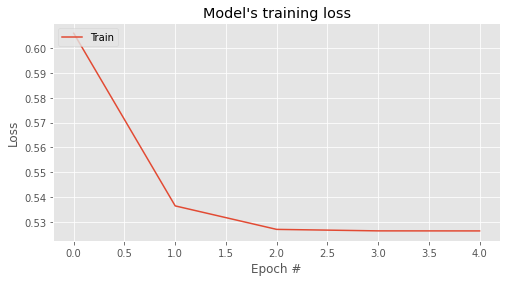

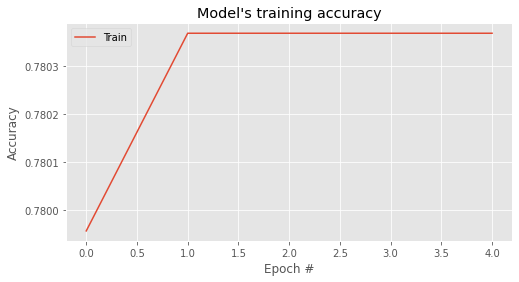

In [ ]:
plot_loss(history)
plot_accuracy(history)

_How can we save these plots?_

## Saving a model

To save the trained model we will basically do two things:

1. Serialize the model into a JSON file, which will save the architecture of our model.
2. Serialize the weights into a HDF5 file, which will save all parameters of our model.

In [ ]:
# Serialize model to JSON:
model_json = model.to_json()
with open("segmentation_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5 (h5py needed):
model.save_weights("segmentation_model.h5")
print("Model saved to disk.")

Model saved to disk.


## Downloading a model

We just need to import the Google Colab module and download the specified files.

In [ ]:
from google.colab import files

model_files = ['segmentation_model.json', 'segmentation_model.h5']
for file in model_files:
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Loading a trained model
We will basically do three things:

1. Load the model from a JSON file.
2. Load the weights from a HDF5 file.
3. (Re)Compile the trained model.

In [ ]:
# Load json and create model:
from tensorflow.keras.models import model_from_json

json_file = open('segmentation_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into loaded model:
loaded_model.load_weights("segmentation_model.h5")
print("Model loaded from disk.")

Model loaded from disk.


In [ ]:
# Evaluate loaded model on test data:
loaded_model.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

score = loaded_model.evaluate(x_test, y_test, verbose=1)
print(f'Test accuracy: {score[1]}')

NameError: ignored

## Predicting from new data

Now that we have a trained model, how do we use it?

It is as simple as follows:

In [ ]:
# Let's predict from out testing folder:
testing_path = sorted(glob("/content/membrane/test/*"))

# Load test image for prediction:
img_index = 5
img = cv2.imread(testing_path[img_index])
img = img[:, :, 0]

# Transform input image for testing:
test_img = cv2.resize(img, (32, 32))
test_img = test_img.reshape(1, 32, 32, 1).astype('float32')
print(test_img.shape)

# Predict and transform output image:
prediction = model.predict(test_img)
prediction = prediction.reshape(32, 32).astype('float32')
#prediction = cv2.resize(prediction, (512, 512))
print(prediction.shape)

In [ ]:
# Display first element from (x_train, y_train):
plt.figure()
plt.title("Original image:")
plt.imshow(img, cmap="gray")
plt.grid(False)

plt.figure()
plt.title("Predicted output:")
plt.imshow(prediction, cmap="gray")
plt.grid(False)